In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Set up
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_preds import *
from src.models.EMOS_local.EMOS_local_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

2023-06-23 12:50:59.607483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-23 12:50:59.607526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 1. Load Predictions

In [12]:
# EMOS_global
EMOS_global_t2m_preds = EMOS_global_load_preds("t2m")
EMOS_global_ws10_preds = EMOS_global_load_preds("ws10")

# EMOS_global
EMOS_local_t2m_preds = EMOS_local_load_preds("t2m")
EMOS_local_ws10_preds = EMOS_local_load_preds("ws10")

# EMOS_global
DRN_t2m_preds = DRN_load_preds("t2m")
DRN_ws10_preds = DRN_load_preds("ws10")

<IPython.core.display.Javascript object>

### 2. Load Matching Ground Truth Values

In [4]:
t2m_ground_truth = ldpd.load_data_all_test_proc_denorm()[2].t2m_test_truth
ws10_ground_truth = ldpd.load_data_all_test_proc_denorm()[5].ws10_test_truth

<IPython.core.display.Javascript object>

### 2.  PIT Histograms

In [14]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def plot_pit_histogram(pred_array, truth_array, num_bins=100, ax=None):
    """
    Plots the Probability Integral Transform (PIT) Histogram for the predictions and truth values.
    
    Args:
        pred_array (np.array): Predictions array of shape (357, 120, 130, 2) with last dimension holding mean and standard deviation.
        truth_array (np.array): Ground truth array of shape (357, 120, 130).
        num_bins (int): Number of bins for the histogram. Defaults to 100.
        ax (matplotlib.axes.Axes): Axis on which to plot the histogram. If None, a new axis is created. Defaults to None.
    
    Returns:
        None. Plots the PIT Histogram.
    """

    # If no axis is provided, create a new one
    if ax is None:
        fig, ax = plt.subplots()

    # Reshape the arrays to have shape (-1, 2) and (-1) for predictions and truth respectively
    pred_array_reshaped = pred_array.reshape(-1, 2)
    truth_array_reshaped = truth_array.reshape(-1)

    # Get mean and standard deviation predictions
    mean_pred = pred_array_reshaped[:, 0]
    std_pred = np.abs(
        pred_array_reshaped[:, 1]
    )  # take the absolute of the standard deviation predictions

    # Compute PIT values
    PIT_values = norm.cdf(truth_array_reshaped, loc=mean_pred, scale=std_pred)

    # Flatten the PIT_values array
    PIT_values_flattened = PIT_values.flatten()

    # Plot the PIT Histogram on the given axis
    ax.hist(
        PIT_values_flattened, bins=num_bins, density=True, alpha=0.75, edgecolor="black"
    )
    ax.set_title("PIT Histogram")
    ax.set_xlabel("PIT Value")
    ax.set_ylabel("Density")

    # Show the plot if it's on a new axis
    if ax is None:
        plt.show()

<IPython.core.display.Javascript object>

In [40]:
def plot_pit_histogram_all(
    pred_arrays, truth_arrays, num_bins=100, ax=None, title=None
):
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    for count, lead in enumerate([1, 16, 31]):
        plot_pit_histogram(
            pred_arrays[count],
            truth_arrays.isel(lead_time=lead).values,
            num_bins=num_bins,
            ax=axs[count],
        )
        axs[count].set_title(f"PIT histogram: Lead time: {lead - 1}")
        if title != None:
            fig.suptitle(title, fontsize=16)

<IPython.core.display.Javascript object>

#### 2.1 t2m

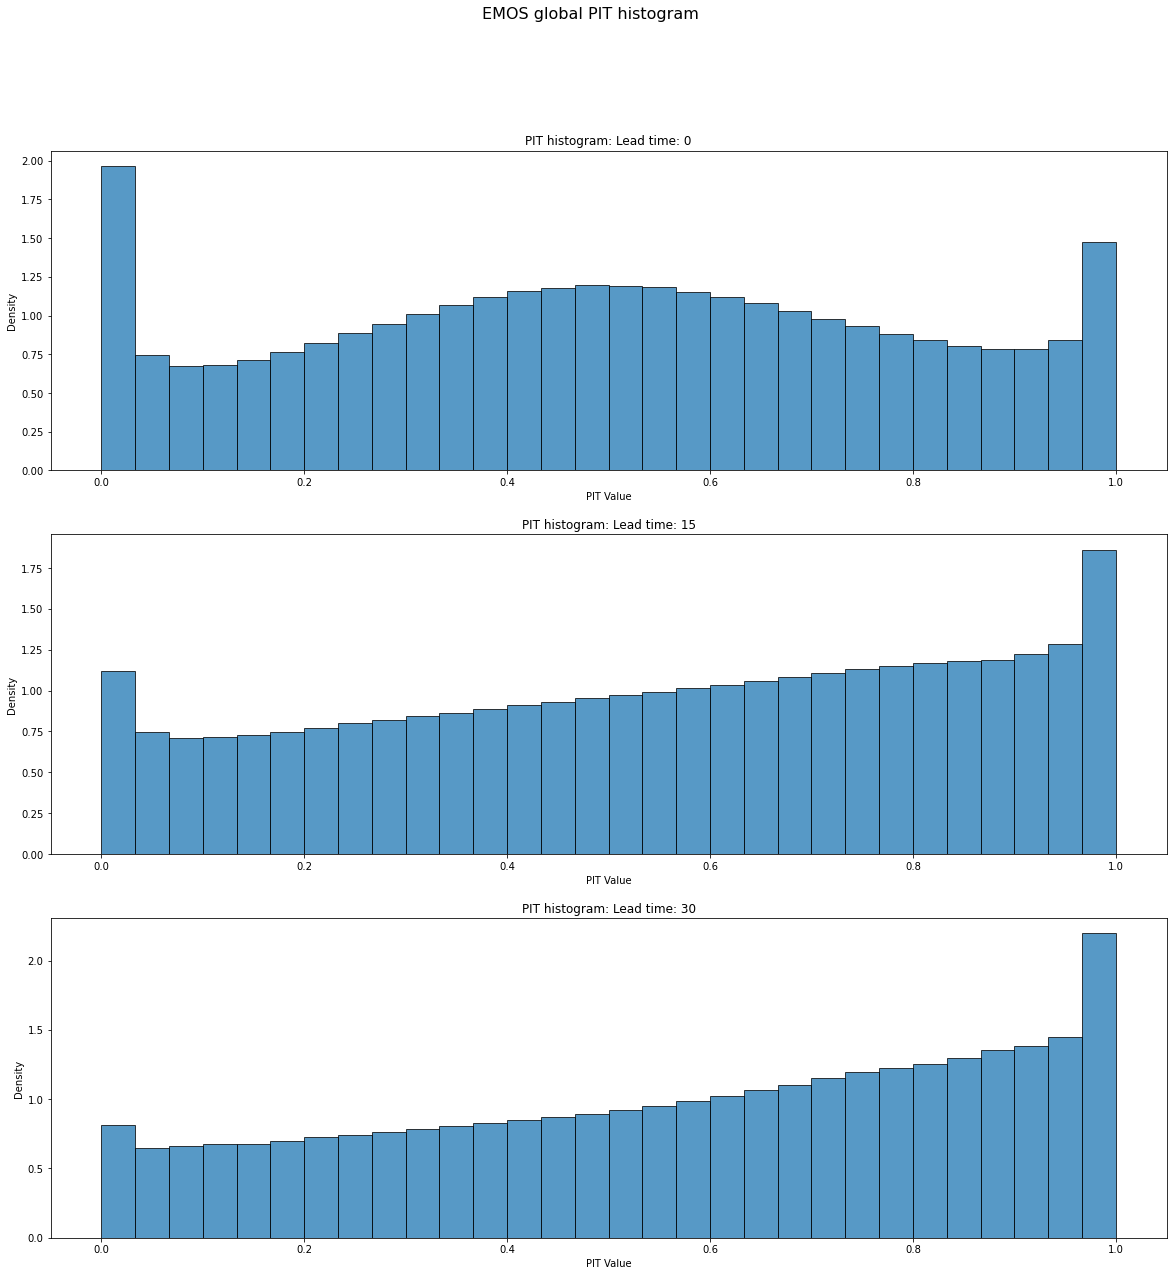

<IPython.core.display.Javascript object>

In [41]:
plot_pit_histogram_all(
    EMOS_global_t2m_preds,
    t2m_ground_truth,
    num_bins=30,
    title="EMOS global PIT histogram",
)

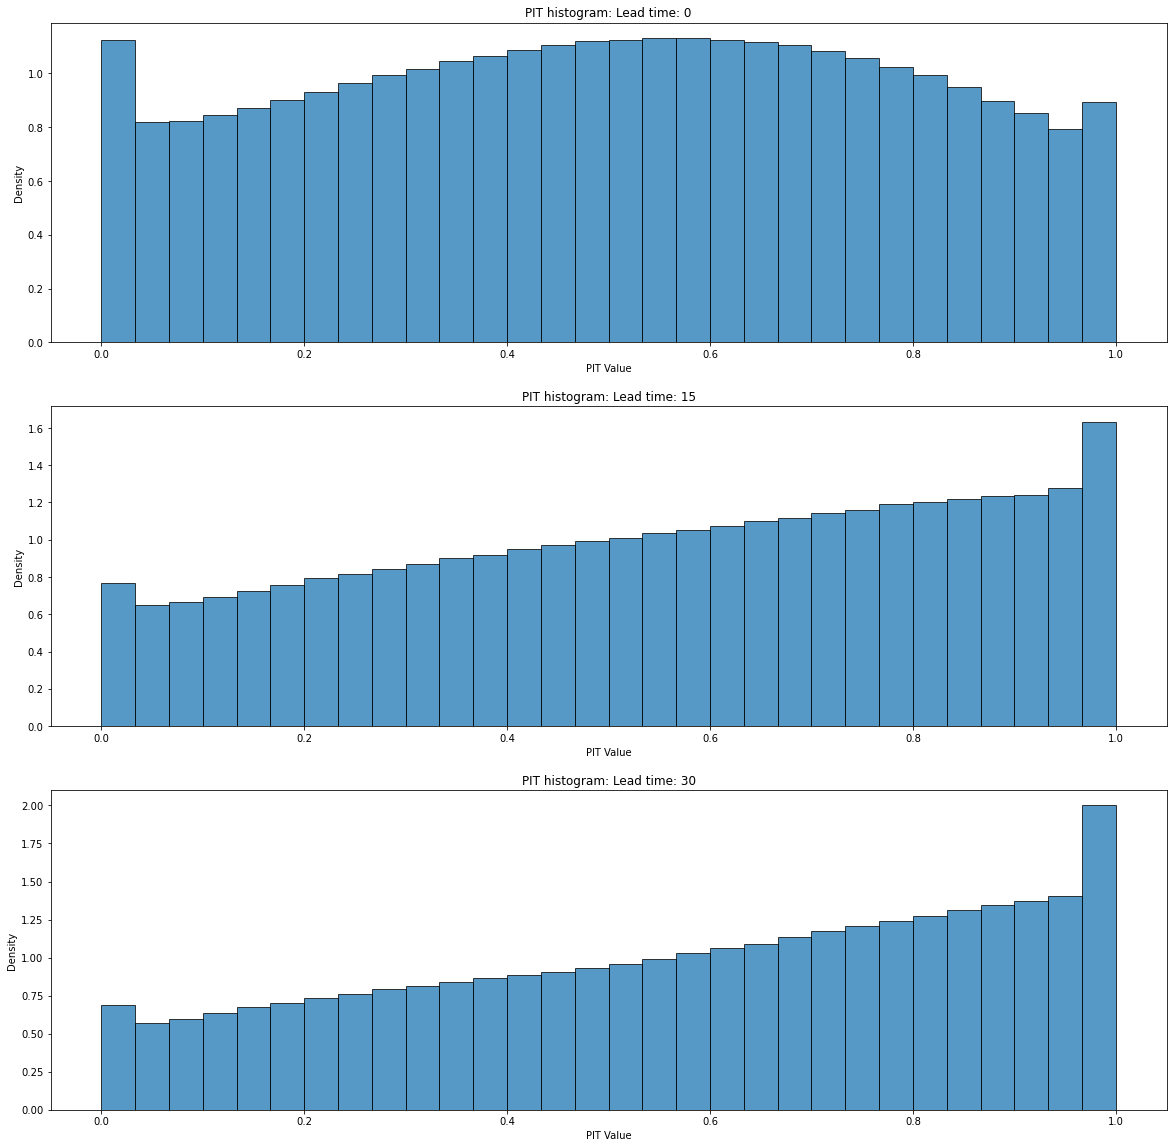

<IPython.core.display.Javascript object>

In [42]:
plot_pit_histogram_all(EMOS_local_t2m_preds, t2m_ground_truth, num_bins=30)

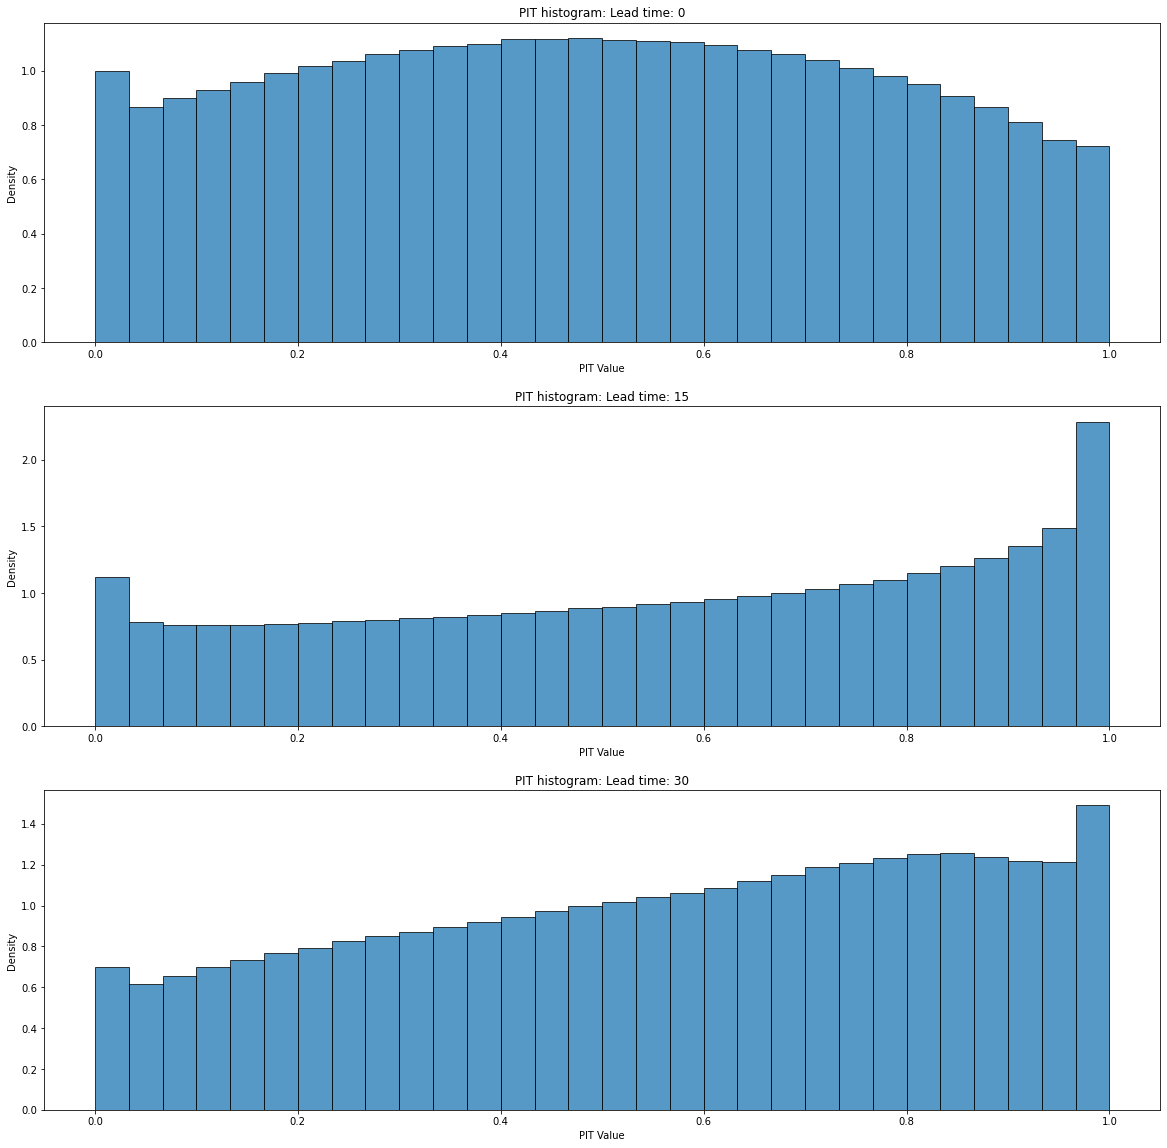

<IPython.core.display.Javascript object>

In [43]:
plot_pit_histogram_all(DRN_t2m_preds, t2m_ground_truth, num_bins=30)

#### 2.2 ws10

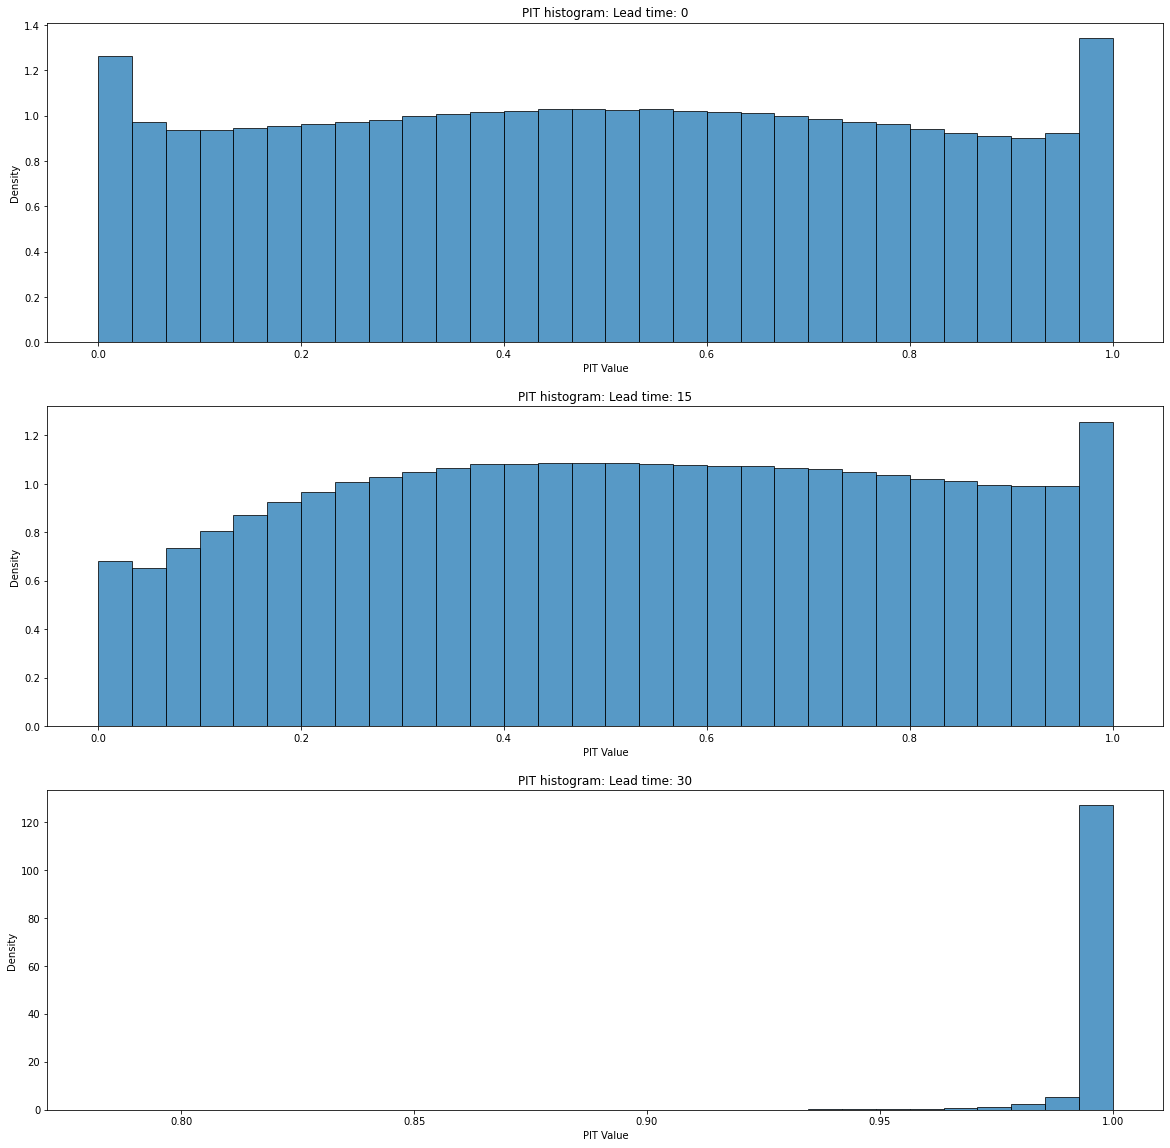

<IPython.core.display.Javascript object>

In [44]:
plot_pit_histogram_all(EMOS_global_ws10_preds, ws10_ground_truth, num_bins=30)

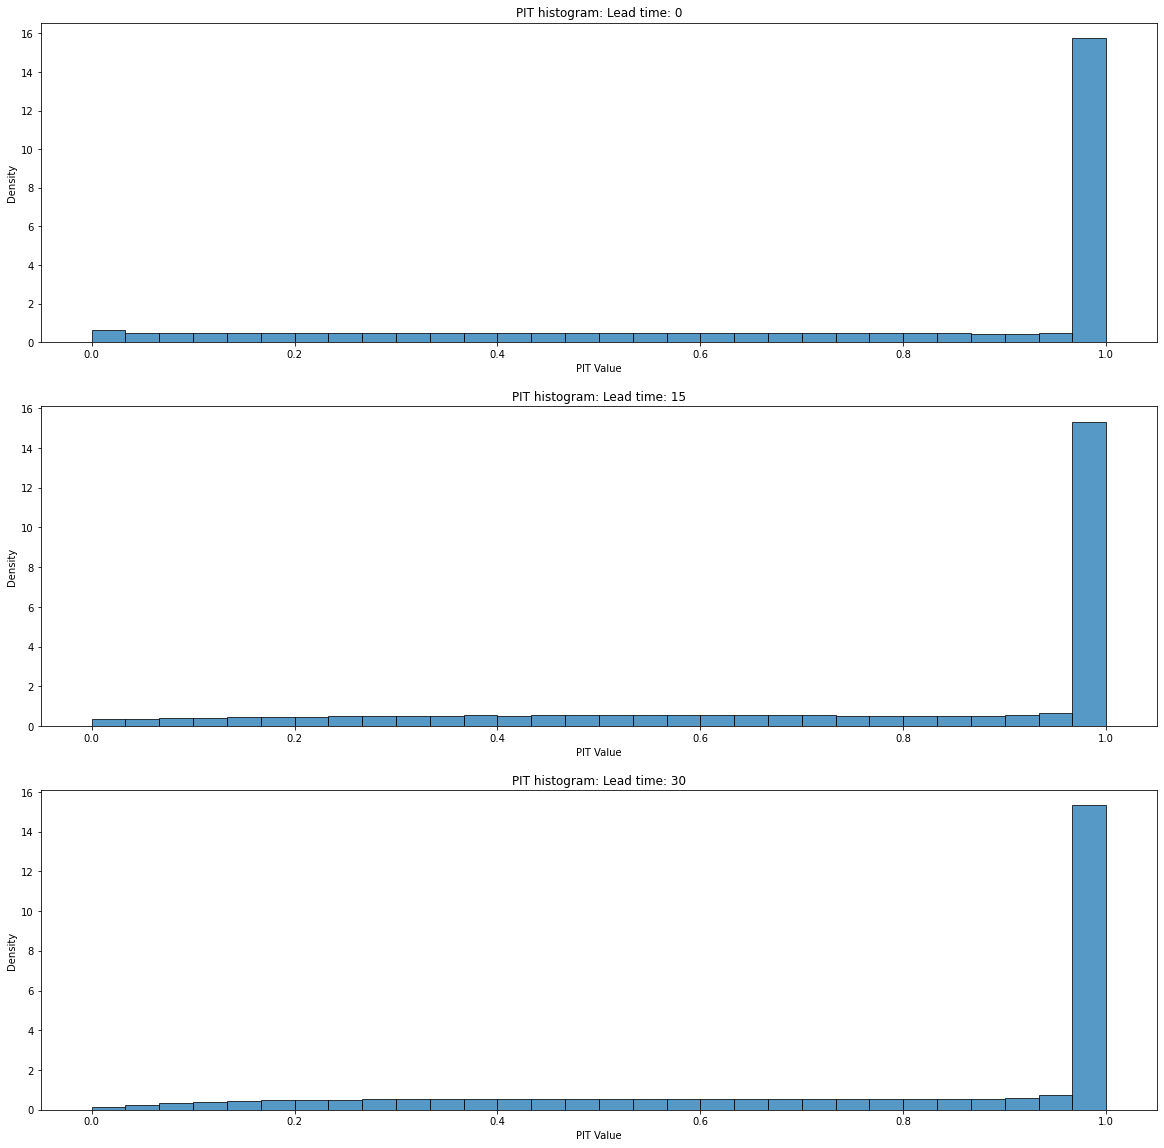

<IPython.core.display.Javascript object>

In [45]:
plot_pit_histogram_all(EMOS_local_ws10_preds, ws10_ground_truth, num_bins=30)

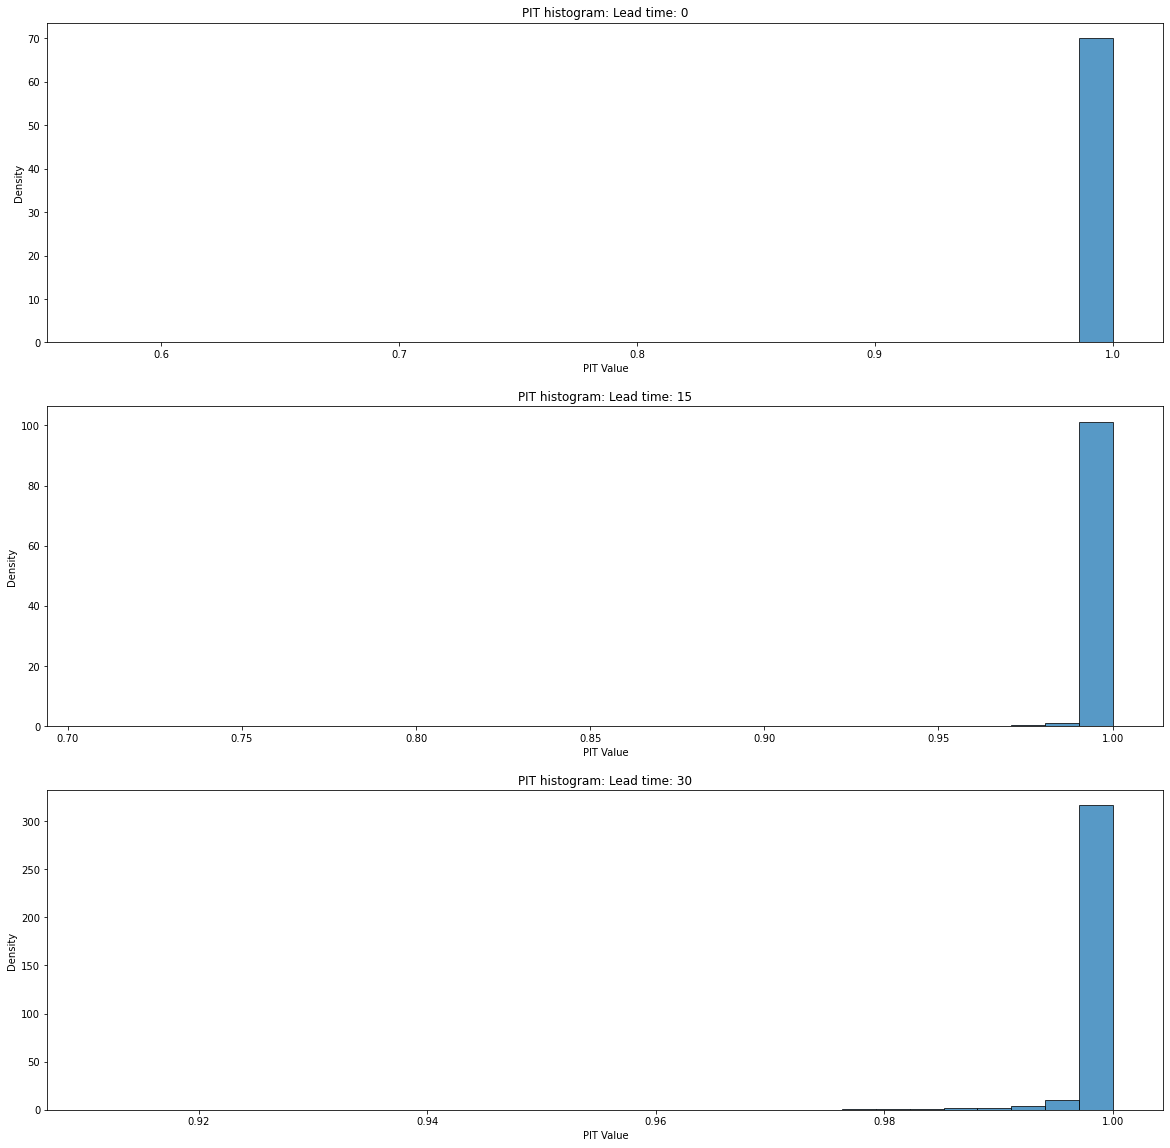

<IPython.core.display.Javascript object>

In [46]:
plot_pit_histogram_all(DRN_ws10_preds, ws10_ground_truth, num_bins=30)